# Natural Language Processing
Of growing importance in many products today is natural language processing (or NLP). It's uses can vary from something simple like detecting if an email is likely to be spam (as is demonstrated below) to generating closed-captions on YouTube videos.

In [1]:
import numpy as np
import nltk # For tokenizing the sentences
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords # Just a big list of words that add no meaning e.g. 'it'
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chandler/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chandler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv("./data/Spam_Email_For_NLP.csv")
df.head()

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6


In [4]:
df['CATEGORY'].value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

We have 3900 email messages that are not spam and 1896 that are spam. These datasets are slightly imbalanced but not to the extent that it should cause issues during training.

## Tokenzing
First we need to tokenize, tokenizing is the process of stripping unecessary characters from a string and splitting into word-by-word. Here I use the NLTK library to do this quickly.

In [5]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
test_message = "Hello Mum,\nhow are you this morning, just thought I would let you know I left my 'car' keys at home!!! Anyway see you <b>later</b>"

test_message_tokenized = tokenizer.tokenize(test_message)
test_message_tokenized[:6]

['Hello', 'Mum', 'how', 'are', 'you', 'this']

In [6]:
# It will be much easier if we move everything to lowercase now
test_message_lowercase = [t.lower() for t in test_message_tokenized]
test_message_lowercase[:6] # Note, lowercasing is a choice

['hello', 'mum', 'how', 'are', 'you', 'this']

In [7]:
lemmatizer = WordNetLemmatizer()
test_message_lem_tokens = [lemmatizer.lemmatize(t) for t in test_message_lowercase]
test_message_lem_tokens[:10]

['hello',
 'mum',
 'how',
 'are',
 'you',
 'this',
 'morning',
 'just',
 'thought',
 'i']

In [8]:
stopwords = stopwords.words('english')
test_message_useful_tokens = [t for t in test_message_lem_tokens if t not in stopwords]
test_message_useful_tokens

['hello',
 'mum',
 'morning',
 'thought',
 'would',
 'let',
 'know',
 'left',
 'car',
 'key',
 'home',
 'anyway',
 'see',
 'b',
 'later',
 'b']

Now we have demonstrated how each step of the processing works, I wrap all the steps up into a function so it is easy to use later.

In [9]:
def message_to_token_list(s):
    # Takes a message and tokenizes it, makes the tokens lowercase then Lemmatizes it.
    # finally we remove "fluff" (words like it, and etc.) by searching NLTK's stopwords
    tokens = tokenizer.tokenize(s)
    lower_case_tokens = [t.lower() for t in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lower_case_tokens]
    useful_tokens = [t for t in lemmatized_tokens if t not in stopwords]
    return useful_tokens

In [10]:
df = df.sample(frac=1, random_state=42) # Shuffle the dataframe randomly before doing a train/test split
df = df.reset_index(drop=True)

# Do the train/test split
train_max_idx = int(len(df) * 0.8)
train_df, test_df = df[:train_max_idx], df[train_max_idx:]

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [11]:
token_counter = {}

for message in train_df['MESSAGE']:
    tokens = message_to_token_list(message)

    for token in tokens:
        if token in token_counter: # Searches the keys
            token_counter[token] += 1
        else:
            token_counter[token] = 1

len(token_counter)

78191

Decide on a simple feature set to use, we could make our model more complex by including more features.

In [13]:
def keep_token(processed_token, threshold):
    if processed_token not in token_counter:
        return False
    else:
        return token_counter[processed_token] > threshold

In [14]:
features = set()

for token in token_counter:
    if keep_token(token, 10000):
        features.add(token)

features

{'3d', 'b', 'br', 'com', 'font', 'http', 'nbsp', 'p', 'size', 'td', 'tr'}

In [57]:
features = list(features)
token_to_index_map = {k: v for k, v in zip(features, range(len(features)))}

# What we are doing here is known as a "bag of words" approach, in this approach we just count up the occurences of
# (assumed) "important" words
def message_to_count_vector(m):
    count_vector = np.zeros(len(features))
    processed_token_list = message_to_token_list(m)
    
    for t in processed_token_list:
        if t not in features:
            continue
        count_vector[token_to_index_map[t]] += 1
    return count_vector

## Building Training Data

In [19]:
# Necessary ML imports
from sklearn.preprocessing import MinMaxScaler

In [58]:
def df_to_X_y(temp_df):
    y = temp_df['CATEGORY'].to_numpy().astype(np.int32)
    messages = temp_df['MESSAGE']
    count_vectors = []

    for m in messages:
        count_vector = message_to_count_vector(m)
        count_vectors.append(count_vector)

    X = np.array(count_vectors).astype(np.int32)
    return X, y

In [59]:
X_train, y_train = df_to_X_y(train_df)
X_test, y_test = df_to_X_y(test_df)

In [60]:
X_train.shape, X_test.shape

((4636, 11), (1160, 11))

In [62]:
scaler = MinMaxScaler().fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

## Building An ML Model

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve
from xgboost import XGBClassifier

In [64]:
model = LogisticRegression()
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       815
           1       1.00      0.35      0.52       345

    accuracy                           0.81      1160
   macro avg       0.89      0.67      0.70      1160
weighted avg       0.85      0.81      0.77      1160



In [65]:
model2 = RandomForestClassifier()
model2.fit(X_train, y_train)
print(classification_report(y_test, model2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       815
           1       0.87      0.57      0.69       345

    accuracy                           0.85      1160
   macro avg       0.86      0.77      0.79      1160
weighted avg       0.85      0.85      0.84      1160



In [72]:
bdt = XGBClassifier(n_estimators=15, max_depth=5)
bdt.fit(X_train, y_train)
print(classification_report(y_test, bdt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       815
           1       0.95      0.54      0.69       345

    accuracy                           0.86      1160
   macro avg       0.90      0.77      0.80      1160
weighted avg       0.87      0.86      0.84      1160



As usual from the, very basic, classification report it seems the XGBClassifier reigns supreme! We can correctly identify spam 95% of the time and correctly identify non-spam 84% of the time. Not bad for a very simple BOW (bag of words) approach.

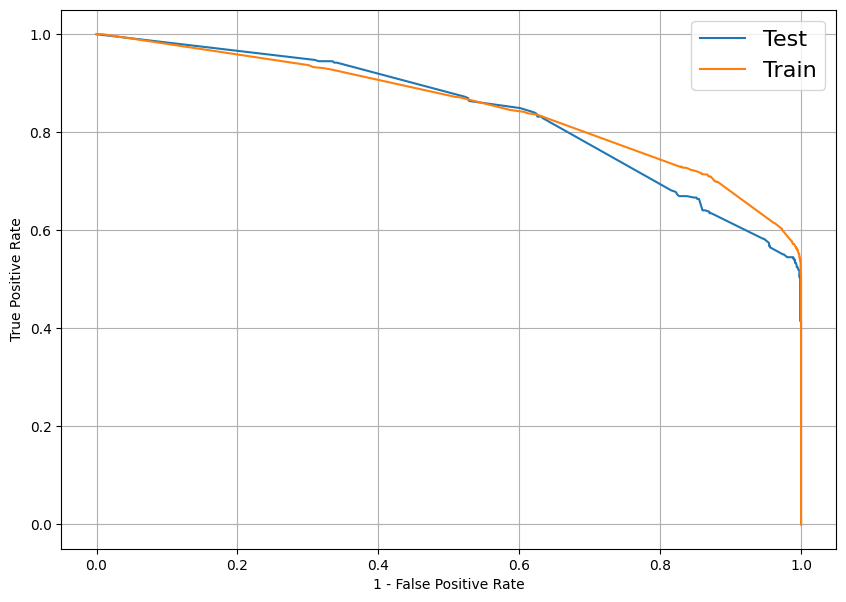

In [86]:
fpr, tpr, thresholds = roc_curve(y_test, bdt.predict_proba(X_test)[:,1])
fpr_train, tpr_train, thresholds = roc_curve(y_train, bdt.predict_proba(X_train)[:,1])
fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(1 - fpr, tpr, label="Test")
ax.plot(1 - fpr_train, tpr_train, label="Train")
ax.set_xlabel("1 - False Positive Rate")
ax.set_ylabel("True Positive Rate")
plt.legend(fontsize=16)
plt.grid()
plt.show()

By using the ROC curve we can tune our thresholds in line with what we want from our model. For example we could move the threshold very high up e.g. $P(isSpam)=0.9$ to ensure we don't wrongly classify any non-spam emails. Conversely we could ensure we remove all the junk - at the risk of rejecting more non-spam emails.

We can also see from this ROC curve that we are unlikely to be overfitting since the curves show similar behaviour for train and test, the reason for the difference is likely the small smaple size.